## Assignment - Syntactic Analysis

### Table of Contents

1. Problem Statement 
2. Data Preparation
3. Build the vanilla Viterbi based POS tagger
4. Viterbi Modification-Technique 1 to handle unknown words
5. Viterbi Modification-Technique 2 to handle unkown words and improve accuracy
6. Model Evaluation
7. Summary


### 1. Problem Statement

In this assignment, we need to modify the Viterbi algorithm to solve the problem of unknown words using at least two techniques.

##### Here are the High level steps we need to acomplish.

1. Write the vanilla Viterbi algorithm for assigning POS tags (i.e. without dealing with unknown words) 
2.  Solve the problem of unknown words using at least two techniques. 
3.  Compare the tagging accuracy after making these modifications with the vanilla Viterbi algorithm.
4.  List down at least three cases from the sample test file (i.e. unknown word-tag pairs) which were incorrectly tagged by the original Viterbi POS tagger and got corrected after your modifications


### 2. Data Preparation

* Import required libraries
* For this assignment, we will use the Treebank dataset of NLTK with the 'universal' tagset. The Universal tagset of NLTK comprises only 12 coarse tag classes.
* Split data into 95:5 ratio for train and test.
* Data analysis like no.of train set, types of tag set, frequent tag sets.
* create functions to calculate Emission probability and Transition probability.

In [1]:
#Importing libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize


In [2]:
# reading the Treebank tagged 'universal' sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [3]:
# first few tagged sentences
print(len(nltk_data))  #no of tagged sentences
print(nltk_data[:3])

#We have around 3914 sentences from the dataset.

3914
[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'

In [4]:
# Splitting into train and test into 95:5 ratio. 
random.seed(1234)
train_set, test_set = train_test_split(nltk_data,test_size=0.05)

print(len(train_set))
print(len(test_set)) 

#Data is split into 95:5 ratio. Keeping the validation set small to restrict the runtime.

3718
196


In [5]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

#We have 95K words in train set.

95527

In [6]:
# Which is the most frequent tag in the corpus
from collections import Counter

tags = [pair[1] for pair in train_tagged_words]
tag_counts = Counter(tags)
tag_counts.most_common()

# Noun is the most common POS tag followed by VERB and then by '.'
# There are 12 unique POS tags in the data set.

[('NOUN', 27404),
 ('VERB', 12883),
 ('.', 11140),
 ('ADP', 9330),
 ('DET', 8254),
 ('X', 6296),
 ('ADJ', 6060),
 ('NUM', 3350),
 ('PRT', 3052),
 ('ADV', 3013),
 ('PRON', 2585),
 ('CONJ', 2160)]

In [7]:
# Which word is most commonly assigned to the tag '.'
p_tags = [pair for pair in train_tagged_words if pair[1].lower() == '.']
p_counts = Counter(p_tags)
p_counts.most_common()[:10]

#Punctuation marks and character groups used in to delimit linguistic units is tagged to '.'

[((',', '.'), 4665),
 (('.', '.'), 3634),
 (('$', '.'), 680),
 (('``', '.'), 668),
 (("''", '.'), 652),
 (('--', '.'), 213),
 ((';', '.'), 159),
 ((':', '.'), 132),
 (('-RRB-', '.'), 108),
 (('-LRB-', '.'), 102)]

In [8]:
# Which word is most commonly assigned to the tag '.'
x_tags = [pair for pair in train_tagged_words if pair[1] == 'X']
x_counts = Counter(x_tags)
x_counts.most_common()[:10]

# The tag X is used for words that for some reason cannot be assigned to a real part-of-speech category.
# Words containg patterns with '*' symbols in it.
# Numerical 0 is also tagged to X instead of Num.

[(('*-1', 'X'), 1067),
 (('0', 'X'), 1046),
 (('*', 'X'), 930),
 (('*T*-1', 'X'), 770),
 (('*U*', 'X'), 698),
 (('*-2', 'X'), 352),
 (('*T*-2', 'X'), 329),
 (('*-3', 'X'), 126),
 (('*T*-3', 'X'), 94),
 (('*ICH*-1', 'X'), 64)]

In [9]:
# Get all unique word vocabulary from the data set. Also called as tokens 

tokens = [pair[0] for pair in train_tagged_words]
train_vocabulary_set = set(tokens)
print(len(train_vocabulary_set))

#There are around 12k unique Vocabulary in train set.

12095


In [10]:
# Get all unique POS tags from the data set. 
tag_set = sorted(set([pair[1] for pair in train_tagged_words]))
print(len(tag_set))
print(tag_set)

#There are 12 tag sets in the tagged word set. This will be used for our training.

12
['.', 'ADJ', 'ADP', 'ADV', 'CONJ', 'DET', 'NOUN', 'NUM', 'PRON', 'PRT', 'VERB', 'X']


In [11]:
# computing P(w/t) and storing in T x V matrix

t = len(tag_set)
v = len(train_vocabulary_set)
w_given_t = np.zeros((t, v))

In [12]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

#Heatmap 
def plotheatmap(df,Title,Figsize=None):
    
    f,ax= plt.subplots(1,1,figsize=Figsize)   
    sns.heatmap(df,annot=True)
    ax.set_title(Title)
    
    #Fix 3.11 matplot version issue by setting the limits manually.
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    
    
    plt.show()

In [13]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(tag_set), len(tag_set)), dtype='float32')
for i, t1 in enumerate(list(tag_set)):
    for j, t2 in enumerate(list(tag_set)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [14]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(tag_set), index=list(tag_set))

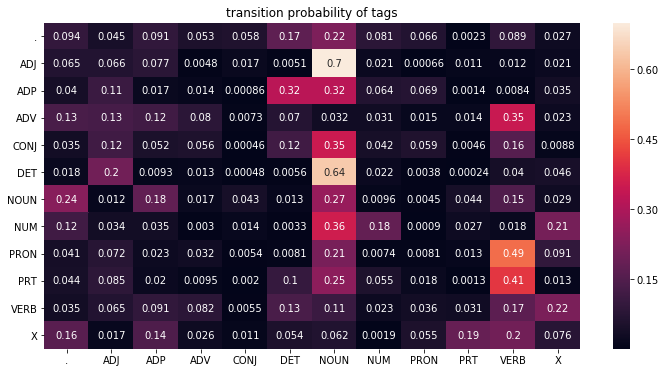

In [15]:
plotheatmap(tags_df,"transition probability of tags",Figsize=(12, 6))

#Adjective followed by a Noun has highest probability of 0.7.
#Determiners followed by Noun comes next with 0.64 probability.
#Verbs are precided by either Pronouns or Particles or Adverbs with a probability of 0.48, 0.4 and 0.34 respectively.

In [16]:
#Transition probability, given previous tag is start of the sentence.
tags_df.loc['.',:]

# Words starting with Noun is highest with 0.22 
# Determiners also has high probability of 0.17 to start the sentence.

.       0.093716
ADJ     0.044524
ADP     0.091203
ADV     0.053052
CONJ    0.057810
DET     0.172172
NOUN    0.222890
NUM     0.080521
PRON    0.065619
PRT     0.002334
VERB    0.088959
X       0.027110
Name: ., dtype: float32

### 3. Build the vanilla Viterbi based POS tagger

Vanilla Viterbi algorithm works as follows:

* For each word, we compute the P(tag|word) for each tag in the tag set and then assign the tag having the max P(tag/word).

* P(tag|word)  = (emission probability of the word-tag pair) * (transition probability from the previous tag).

In [114]:
# Create function to calculate vanilla Viterbi Heuristic algorithm for a given word and train set.

def Viterbi_Vanilla(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))


#Create Function to check accuracy
def check_accuracy(tagged_set, test_run_base,msg):
    check = [i for i, j in zip(tagged_set, test_run_base) if i == j] 
    accuracy = round((len(check)/len(tagged_set))*100,2)
    print(msg,accuracy,end='%')

# Create Function to check incorrect tag cases.     
def check_diff(tagged_set,test_run_base):
    incorrect_tagged_cases = [[test_run_base[i-1],j[0],j[1],test_run_base[i+1]] for i, j in enumerate(zip(tagged_set, test_run_base)) if j[0]!=j[1]]
    diff_df = pd.DataFrame(incorrect_tagged_cases, columns = ['Previous Word-Tag','Predicted Word-Tag','Actual Word-Tag','Next Word-Tag'])
    return diff_df

#Create function to generate a sample set of 5 sentences from test set 
def generate_sampl_set(num):
    random.seed(num)

    # choose random 5 sents
    rndom = [random.randint(1,len(test_set)) for x in range(5)]

    # list of sents
    test_run = [test_set[i] for i in rndom]

    # list of tagged words
    test_run_base = [tup for sent in test_run for tup in sent]

    # list of untagged words
    test_tagged_words = [tup[0] for sent in test_run for tup in sent]
    
    return test_run_base,test_tagged_words


In [21]:
#Test on Vanilla Viterbi model
test_run_base,test_tagged_words = gen_sampl_set(123)
start = time.time()
tagged_set1 = Viterbi_Vanilla(test_tagged_words)
end = time.time()
print("Time taken in seconds: ", round(end-start,2))

check_accuracy(tagged_set1,test_run_base,'Accuracy of vanilla Viterbi model: ')

check_diff(tagged_set1,test_run_base)

Time taken in seconds:  46.07
Accuracy of vanilla Viterbi model:  89.13%

,Previous Word-Tag,Predicted Word-Tag,Actual Word-Tag,Next Word-Tag
0,"(proposed, VERB)","(fixes, .)","(fixes, NOUN)","(for, ADP)"
1,"(``, .)","(program-trading, ADJ)","(program-trading, NOUN)","(volatility, NOUN)"
2,"(The, DET)","(goverment, .)","(goverment, NOUN)","(counts, VERB)"
3,"(goverment, NOUN)","(counts, NOUN)","(counts, VERB)","(money, NOUN)"
4,"(Dodge, NOUN)","(counts, NOUN)","(counts, VERB)","(contracts, NOUN)"
5,"(Jim, NOUN)","(Enzor, .)","(Enzor, NOUN)","(of, ADP)"
6,"(Atlanta, NOUN)","(defends, .)","(defends, VERB)","(program, NOUN)"
7,"(market, NOUN)","(back, PRT)","(back, ADV)","(up, ADP)"
8,"(back, ADV)","(up, ADV)","(up, ADP)","(after, ADP)"
9,"(has, VERB)","(nonetheless, .)","(nonetheless, ADV)","(been, VERB)"


#### Observations from vanilla Viterbi Model

* Most of the unknown words are tagged as '.' since its the first tag
* For unknown words Emission probability will be 0 and hence it takes the default flag.
* In order to resolve this we can consider only the transition probability and evaluate the accuracy.


### Solve the problem of unknown words

In [63]:
# list unknown words in sample test set compared to train set.

test_tagged_set = set([tup[0] for sent in test_run for tup in sent])
train_tagged_set = set([tup[0] for sent in train_set for tup in sent])

unknown_words = list(test_tagged_set - train_tagged_set)
print("Total Unknown words :", len(unknown_words))
print("\n")
print("Unknown Words :", unknown_words)

#There are 6 words in the sample set which are not in train set.
# All these 6 words are tagged as '.', which is first tag out of 12 tag classes universal tag set.

Total Unknown words : 6


Unknown Words : ['striving', 'fixes', 'goverment', 'defends', 'Enzor', 'nonetheless']


In [71]:
#Check the emission and transition probabilities of unknown words.

print("\n", "striving")
print('Emmision probability: ',word_given_tag('striving', 'VERB')[0]/word_given_tag('striving', 'VERB')[1])

for t in tag_set:
    print ('Transition Probability for tag -',t ,tags_df.loc['VERB', t])

print("\n", "goverment")
print('Emmision probability: ',word_given_tag('goverment', 'NOUN')[0]/word_given_tag('goverment', 'NOUN')[1])
print ('Transition Probability: ',tags_df.loc['NOUN','DET'])



# Emission probability of both words are 0
# Transition probability of words are non zero
# Since Viterbi considers state probability, unknown words always end up taking first default tag.
# To address this we can consider only tranition probability for unknown words in our first technique.


 striving
Emmision probability:  0.0
Transition Probability for tag: . 0.03531786
Transition Probability for tag: ADJ 0.06496934
Transition Probability for tag: ADP 0.09105022
Transition Probability for tag: ADV 0.082201354
Transition Probability for tag: CONJ 0.0055111386
Transition Probability for tag: DET 0.13490647
Transition Probability for tag: NOUN 0.10898083
Transition Probability for tag: NUM 0.023286501
Transition Probability for tag: PRON 0.03562835
Transition Probability for tag: PRT 0.031203913
Transition Probability for tag: VERB 0.16805092
Transition Probability for tag: X 0.21889311

 goverment
Emmision probability:  0.0
Transition Probability:  0.013246241


In [62]:
# list all unknown words in whole test set compared to train set.

test_tagged_set = set([tup[0] for sent in test_set for tup in sent])
train_tagged_set = set([tup[0] for sent in train_set for tup in sent])

unknown_words = list(test_tagged_set - train_tagged_set)
print("Total Unknown words :", len(unknown_words))
print("\n")
print("Unknown Words :", unknown_words)

# There are total of 313 unknown words in the test set.
# words vary from numbers, X tag words with '*' in it and regular words.
# Since we know all numbers fall under NUM tag excep 0, we can default it to NUM in our viterbi modified technique.

Total Unknown words : 313


Unknown Words : ['elementary', '*T*-131', 'pack', 'landing', 'inquiring', 'hitter', 'noble', '139', 'boogieman', 'anticipation', 'presentation', 'interrogated', 'nutrition', 'cardiovascular', 'expense', 'Rusty', 'allies', 'scarcely', 'debenture', 'overtime', 'Sangyo', 'heirs', 'rigged', 'driver', 'broadcasting', 'Rill', 'honorably', '*T*-135', 'nine-month', 'reviewing', 'reimbursed', 'milked', 'riskier', 'Filter', 'cost-control', 'uncanny', '*-93', '1.49', '11\\/16', 'Lobsenz', 'Elliott', 'fielded', '*-117', 'vague', 'striving', 'procurement', 'fixes', 'Compare', 'Goodman', '169.9', 'deprivation', 'longest', 'thunder', 'attributes', '45.75', 'Merchant', 'sake', '29year', 'crossed', 'Anku', 'Protection', 'blackjack', 'gradual', '47.5', 'combat', 'salarymen', 'devouring', 'remodeling', 'twist', 'viewpoints', '221.4', 'Campeau', 'fend', 'shake', 'awarding', 'inhibit', 'Columbus', 'rallying', 'pediatrician', 'aftereffects', 'suburban', 'serviced', 'refinery', 'L

### 4. Viterbi Modification-Technique I
As per the analysis from unknown words,

* For unknow words consider only Transition probability.
* For words containing only numbers, tag it to NUM by default.


In [72]:
# Modification of Viterbi Heuristic algorithm to consider only Transition probability for unknown words and Num words.
def Viterbi_m1(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        num_word=re.search('^[0-9]*.?[0-9]*[0-9]$',word)
        
        #if a word is number and not in train set then assign it to NUM tag
        if num_word and word not in train_vocabulary_set:
            state.append('NUM')
        else:
            for tag in T:
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]
                
                # compute emission and state probabilities
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            
                # modification to the original vanilla viterbi algorithm 
                # If word in unknown then consider only the transition_p 
            
                if word not in train_vocabulary_set:
                
                    state_probability = transition_p
                else:
                    state_probability = emission_p * transition_p
            
            
                p.append(state_probability)
            
            pmax = max(p)
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)] 
            state.append(state_max)
    return list(zip(words, state))


In [112]:
#Test on modified Viterbi model
start = time.time()
tagged_set2 = Viterbi_m1(test_tagged_words)
end = time.time()
print("Time taken in seconds: ", round(end-start,2))

check_accuracy(tagged_set2,test_run_base,'Accuracy of Modified Viterbi Model 1: ')

check_diff(tagged_set2,test_run_base)

Time taken in seconds:  22.22
Accuracy of Modified Viterbi Model 1:  91.3%

,Previous Word-Tag,Predicted Word-Tag,Actual Word-Tag,Next Word-Tag
0,"(proposed, VERB)","(fixes, X)","(fixes, NOUN)","(for, ADP)"
1,"(``, .)","(program-trading, ADJ)","(program-trading, NOUN)","(volatility, NOUN)"
2,"(goverment, NOUN)","(counts, NOUN)","(counts, VERB)","(money, NOUN)"
3,"(Dodge, NOUN)","(counts, NOUN)","(counts, VERB)","(contracts, NOUN)"
4,"(Atlanta, NOUN)","(defends, NOUN)","(defends, VERB)","(program, NOUN)"
5,"(market, NOUN)","(back, PRT)","(back, ADV)","(up, ADP)"
6,"(back, ADV)","(up, ADV)","(up, ADP)","(after, ADP)"
7,"(has, VERB)","(nonetheless, X)","(nonetheless, ADV)","(been, VERB)"
8,"(been, VERB)","(striving, X)","(striving, VERB)","(--, .)"
9,"(colleagues, NOUN)","(dislike, NOUN)","(dislike, VERB)","(*T*-1, X)"


#### Observations after applying Technique 1
* After modifying vanilla Viterbi to consider only Transition probaility for unknown words, Words are not tagged to Default tags now.
* Accuracy has improved significantly from 88% to 92.3%. 
* Since Viterbi Model is Greedy approach, it goes with max probability eventhough other combinations are valid.Hence, some words might be wrongly tagged.
* Also, Viterbu model do not look ahead and just considers previous tag. Hence some tag which are VERB like 'Counts' in this example gets tagged as Noun. To solve this prolem we can look in to previous 2 tags or even Symantic processing.


### 5. Viterbi Modification-Technique 2

1. In this approach we will consider _Morphological feature_ to define POS tag patterns. The internal structure of a word may give useful clues as to the word's category. For example, -ness is a suffix that combines with an adjective to produce a noun.
2. Additionally to morphological cues, we will use _Backoff techniques_ like unigram, bigram and trigram to improve the accuracy.



In [74]:
# Define various morphological cues patterns in English 
patterns = [
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'), # Any word ending with 'ing' or 'ed' or es is a verb
    (r'.*ly$', 'ADV'),                 # Words like really, early are Adverbs.
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'), # words with a hyphen followed by alphabets like 
    (r'.*able$', 'ADJ'),               # Words like agreeable,Measurable are Adjectives   
    (r'.*ful$', 'ADJ'),                # Words like Beautiful, Thankful falls under Adjective tags.
    (r'.*ous$', 'ADJ'),                # Words like dangerous 
        
    (r'^[aA-zZ].*[0-9]+','NOUN'),     # Alpha Numeric words are generally a Noun.
    (r'.*ness$', 'NOUN'),             # Abstract nouns like happiness, loneliness
    (r'.*\'s$', 'NOUN'),              # possessive nouns - words ending with 's
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'.*ers$', 'NOUN'),              # Words like Bankers, employers.
    (r'.*ment$', 'NOUN'),             # Abstract nouns like argument, movement.
    (r'.*town$', 'NOUN'),             # Place names ending with town.
        
    (r'^(0|([*|-|$].*))','X'), # Any special character combination
    (r'.*ould$', 'X'),         # Words like Could, would etc. 
        
    (r'(The|the|A|a|An|an|That|that|This|this|Those|those|These|these)$', 'DET'), # That/this/these/those belong to the category of Demonstrative determiners
    (r'^[0-9]*.?[0-9]*[0-9]$','NUM'),  #All numbers with or without decimals
    (r'.*', 'NOUN')   # If it is not matching any of the above patterns then assign it to Noun by default as it is most frequent POS tag.
    ]

    

In [75]:
# Assign morphological cues to Regex tagger.
regex_tagger = nltk.RegexpTagger(patterns)

#Define Unigram tagger with reges as backoff method.
unigram_tagger = nltk.UnigramTagger(train_set, backoff = regex_tagger)

#Define Bigram tagger with unigram as backoff method.
bigram_tagger = nltk.BigramTagger(train_set, backoff = unigram_tagger)

#Define trigram tagger with bigram as backoff method.
trigram_tagger = nltk.TrigramTagger(train_set, backoff = bigram_tagger)

In [104]:
# Modification of Viterbi Heuristic algorithm to backoff technique to tag unknown words.

def Viterbi_m2(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        
        #Use Trigram tagger for unknow words.
        if word not in train_vocabulary_set:
            
            unknown_word_tag = trigram_tagger.tag_sents([[(word)]])
            for sent in unknown_word_tag:
                for tup in sent:
                    if tup[1] == None:
                        state.append('NOUN')
                    else:
                        state.append(tup[1])
        
        else:
            for tag in T:
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]
                
                # compute emission and state probabilities
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
                state_probability = emission_p * transition_p
                p.append(state_probability)
            
            pmax = max(p)
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)] 
            state.append(state_max)
    return list(zip(words, state))


In [106]:
#Test on modified Viterbi model
start = time.time()
tagged_set3 = Viterbi_m2(test_tagged_words)
end = time.time()
print("Time taken in seconds: ", round(end-start,2))

check_accuracy(tagged_set3,test_run_base,'Accuracy of Modified Viterbi Model 2: ')

check_diff(tagged_set3,test_run_base)

Time taken in seconds:  21.74
Accuracy of Modified Viterbi Model 2:  92.03%

,Previous Word-Tag,Predicted Word-Tag,Actual Word-Tag,Next Word-Tag
0,"(proposed, VERB)","(fixes, VERB)","(fixes, NOUN)","(for, ADP)"
1,"(``, .)","(program-trading, ADJ)","(program-trading, NOUN)","(volatility, NOUN)"
2,"(goverment, NOUN)","(counts, NOUN)","(counts, VERB)","(money, NOUN)"
3,"(Dodge, NOUN)","(counts, NOUN)","(counts, VERB)","(contracts, NOUN)"
4,"(Atlanta, NOUN)","(defends, NOUN)","(defends, VERB)","(program, NOUN)"
5,"(market, NOUN)","(back, PRT)","(back, ADV)","(up, ADP)"
6,"(back, ADV)","(up, ADV)","(up, ADP)","(after, ADP)"
7,"(has, VERB)","(nonetheless, NOUN)","(nonetheless, ADV)","(been, VERB)"
8,"(colleagues, NOUN)","(dislike, NOUN)","(dislike, VERB)","(*T*-1, X)"
9,"(goverment, NOUN)","(counts, NOUN)","(counts, VERB)","(money, NOUN)"


#### Observations after applying Technique 2.

* Model accuracy improved to 92%
* It could tag the words like 'Striving' properly to Verb instead of Noun.
* There are some more words which are tagged incorrectly. These are the limitations of HMM and Viterbi models as it considers previous n tags instead of understanding the context of the sentence.


#### Evaluating tagging accuracy

Lets evaluate some sentences from test file provided in the assignment.

In [79]:
#Read the file and split into sentences.

f = open('Test_sentences.txt')
text = f.read()
sample_test_sent = text.splitlines()
f.close()
sample_test_sent

['Android is a mobile operating system developed by Google.',
 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.',
 "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.",
 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.',
 'Before entering politics, Donald Trump was a domineering businessman and a television personality.',
 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.',
 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.',
 'Show me the cheapest round trips from Dallas to Atlanta',
 'I would like to see flights from Denver to Philadelphia.',
 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.',
 'NASA invited social media users to experienc

In [80]:
# list of untagged words

sample_test_words = [word for sent in sample_test_sent for word in sent.split()]

In [99]:
# tagging the test sentences
tagged_seq_tst = Viterbi_m2(sample_test_words)


In [100]:
#Lets find the POS tagging of 1st sentence. 'Android is a mobile operating system developed by Google.'
tagged_seq_tst[:9]

# All tags have been properly identified for this sentences
# There are some new words like Android and Google which are properly tagged as Noun.

[('Android', 'NOUN'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google.', 'NOUN')]

In [101]:
#Lets find the POS tagging of 1st sentence. 'Android is a mobile operating system developed by Google.'
tagged_seq_tst[60:73]

# Unknown word 'domineering' is tagged as Verb insted of Adjective in this sentence. This is tagged using our morphological cues defined in regex_tagger.
# Except 1 tag, all words are properly tagged.
# Unknow Nouns are identified correctly in this sentence like 'Donald Trump' and 'politics'.


[('Before', 'ADP'),
 ('entering', 'VERB'),
 ('politics,', 'NOUN'),
 ('Donald', 'NOUN'),
 ('Trump', 'NOUN'),
 ('was', 'VERB'),
 ('a', 'DET'),
 ('domineering', 'VERB'),
 ('businessman', 'NOUN'),
 ('and', 'CONJ'),
 ('a', 'DET'),
 ('television', 'NOUN'),
 ('personality.', 'NOUN')]

### 6. Model Evaluation

* Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm
* We will sample 3 random sets to test accuracies with vanilla viterbi model

In [124]:
random_set=['124','123','55']
cnt=1
for num in random_set:
    print("\n ----Comparing tagging accuracy for random set",cnt,"----\n")
    test_run_base,test_tagged_words=generate_sampl_set(num)
    tagged_set_vanilla = Viterbi_Vanilla(test_tagged_words)
    tagged_set_m1 = Viterbi_m1(test_tagged_words)
    tagged_set_m2 = Viterbi_m2(test_tagged_words)
    cnt+=1

    check_accuracy(tagged_set_vanilla,test_run_base,'Accuracy of vanilla Viterbi model: ')
    check_accuracy(tagged_set_m1,test_run_base,'\nAccuracy of Modified Viterbi Model 1: ')
    check_accuracy(tagged_set_m2,test_run_base,'\nAccuracy of Modified Viterbi Model 2: ')
    print("\n")




 ----Comparing tagging accuracy for random set 1 ----

Accuracy of vanilla Viterbi model:  91.07%
Accuracy of Modified Viterbi Model 1:  95.83%
Accuracy of Modified Viterbi Model 2:  96.43%


 ----Comparing tagging accuracy for random set 2 ----

Accuracy of vanilla Viterbi model:  88.89%
Accuracy of Modified Viterbi Model 1:  91.67%
Accuracy of Modified Viterbi Model 2:  92.59%


 ----Comparing tagging accuracy for random set 3 ----

Accuracy of vanilla Viterbi model:  89.32%
Accuracy of Modified Viterbi Model 1:  93.2%
Accuracy of Modified Viterbi Model 2:  94.17%



#### Tagging accuracy Comparison:
* Accuracy varies for each random sample. This is mainly due to unknown words present in that particular sample.
* In general Technique 1 performs better than vanilla Viterbi algorithm in all cases. In case of unknown words, Technique 1 computes transition probability alone helping algorithm to tag words and helps subsequent words to tag accurately with revised state probabilities.
* Technique 2 outperforms in all cases. This technique uses nltk's backoff tagger combined with morphological cues. This is very efficient technique based on second order Markov models that consider triples of consecutive words and regex tagger using morphological cues.



#### Cases which were incorrectly tagged by original POS tagger
Lets look at some specific cases where vanilla Viterbi algorithm incorrectly tagged a word and how it changed with various techniques.

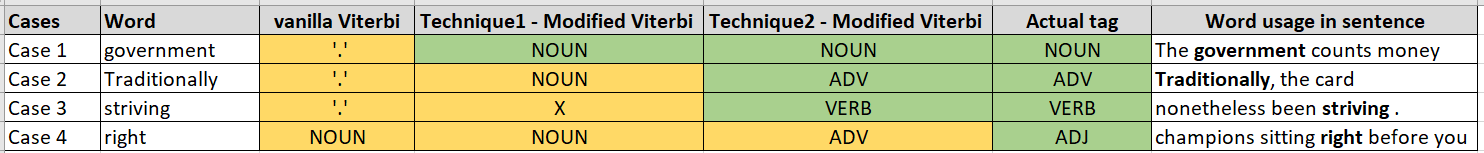

In [ ]:
Case 1: 
    Word Government.

In [125]:
#Check emission and transition probability of some incorrect tagged words after applying Technique 1
print ("Word -> government")
print('Emmision probability: ',word_given_tag('government', 'NOUN')[0]/word_given_tag('government', 'NOUN')[1])

for t in ['NOUN','VERB']:
    print ('Transition Probability for tag t2 '+t+' given t1 as DET ' ,tags_df.loc['DET', t])
    


 government
Emmision probability:  0.0029557728798715517
Transition Probability for tag t2 NOUN given t1 as DET  0.63835716
Transition Probability for tag t2 VERB given t1 as DET  0.03973831


In [126]:
word_given_tag('government', 'NOUN')

(81, 27404)

In [118]:
#Check emission and transition probability of some incorrect tagged words after applying Technique 1
print("\n", "counts")
print('Emmision probability: ',word_given_tag('counts', 'NOUN')[0]/word_given_tag('counts', 'NOUN')[1])

for t in ['NOUN','VERB']:
    print ('Transition Probability for tag t2 '+t+' given t1 as Noun ' ,tags_df.loc['NOUN', t])
    
# 


 counts
Emmision probability:  3.649102320829076e-05
Transition Probability for tag t2 NOUN given t1 as Noun  0.26521677
Transition Probability for tag t2 VERB given t1 as Noun  0.1471683


### 7. Summary

* In general *vanilla Viterbi* is a good algorithm provided strong training set. It could tag accurately for most of the test set. It failed in case of unknown words and in sentences where context of word usage is different.
* *Technique 1* helped in addrressing this issue of unknown words and also inturn helped tagging subsequent words which were incorrectly tagged initially as its state probability changed.
* *Technique 2* using trigram tagger and morphological cues proved very efficient techniques to identify most of the POS tags correctly.Trigram tagger which is based on second order Markov models that consider triples of consecutive words and backed off by bigram, unigram and finally regex tagger proved to be a strong model.

* However, as we saw in this dataset there were several words which couldn't be tagged correctly even after modifications. This showcases some *limitations of Markov models.*
* For *advanced tagging* one can look at some advanced techniques like Conditional random fields or Unsupervised tagging like Baum Welch algorithm.
